# Recursive QAOA

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import os
import joblib

from openqaoa.qaoa_parameters import QAOACircuitParams, create_qaoa_variational_params, Hamiltonian
from openqaoa.devices import create_device
from openqaoa.backends.qaoa_backend import get_qaoa_backend
from openqaoa.optimizers import get_optimizer
from openqaoa.utilities import *
from openqaoa.workflows.optimizer import QAOA, RQAOA
from openqaoa.problems.problem import QUBO, MaximumCut, MinimumVertexCover

In [2]:
# Set plotting style
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
#plt.rcParams['font.size'] = '12'
#plt.rc('font', family='serif', size=600)

sns.axes_style("whitegrid")
sns.set_context("paper", font_scale=2.5)

In [3]:
def random_k_regular_graph_normal_distribution(degree: int,
                           nodes: List[int],
                           seed: int = None,
                           weighted: bool = False,
                           sigma: float = 1.0,
                           mu: float = 0.0,
                           biases: bool = False) -> nx.Graph:
    """
    Produces a random graph with specified number of nodes, each having degree k.

    Parameters
    ----------
    degree: `int`
        Desired degree for the nodes.
    nodes: `list`
        The node set of the graph.
    seed: `int`, optional
        A seed for the random number generator.
    weighted: `bool`, optional
        Whether the edge weights should be uniform or different. If false, all weights are set to 1.
        If true, the weight is set to a random number drawn from the uniform distribution in the
        interval 0 to 1.
    biases: `bool`, optional
        Whether or not the graph nodes should be assigned a weight.
        If true, the weight is set to a random number drawn from the uniform
        distribution in the interval 0 to 1.

    Returns
    -------
    nx.Graph: `Networkx Graph`
        A graph with the properties as specified.
    """
    # Set numpy seed
    np.random.seed(seed=seed)

    # Create a random regular graph on the nodes
    G = nx.random_regular_graph(degree, len(nodes), seed)

    # Relabel nodes
    nx.relabel_nodes(G, {i: n for i, n in enumerate(nodes)})

    # Add edges between nodes
    for edge in G.edges():

        # If weighted attribute is False, all weights are set to 1
        if not weighted:
            G[edge[0]][edge[1]]['weight'] = 1

        # If weighted attribute is True, weights are assigned as random integers
        else:
            G[edge[0]][edge[1]]['weight'] = np.random.normal(mu, sigma)

    # If biases attribute is True, add node weights as random integers
    if biases:
        for node in G.nodes():
            G.nodes[node]['weight'] = np.random.rand()

    return G

In [4]:
def run_Rqaoa_experiment(sigma, graph_seed, optimizer, init_seed, experiment_name='Maxcut_w3R_local_mins'):  
    
    mu = 5.0
    k = 3
    n = 12
    
    # experiment_name = name of the folder to contain all data for this experiment
    # structure of the name: problem_typeOfGraph[optional]_variableToInvestigate
    
    g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

    # Define te problem and translate it into a binary Qubo.
    maxcut_prob = MaximumCut(g)
    maxcut_qubo = maxcut_prob.get_qubo_problem()

    
    # Define the RQAOA object (default rqaoa_type = 'adaptive')
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    R.set_rqaoa_parameters(steps=1, n_cutoff=3)

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    #R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    
    random.seed(init_seed)
    init_beta = random.uniform(0, np.pi/2)
    init_gamma = random.uniform(0, 3*np.pi)

    R.set_circuit_properties(p=1, init_type='custom', variational_params_dict={"betas":[init_beta], "gammas":[init_gamma]}, mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)
    
    maxiter=1000  # for cobyla and rmsprop
    maxfev=2000
    optimizer_method = optimizer  # to keep the otpimizer argument passed to the function and saved in the name from the optimizer used 
    
    if optimizer == "noOptimizer":
        optimizer_method = "rmsprop"
        maxiter=1
        maxfev=2

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer_method, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-6), maxfev=maxfev, maxiter=maxiter, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=False, 
                              cost_progress=True, parameter_log=True)

   
    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    try: 
        os.mkdir(experiment_name) 
    except OSError as error: 
        pass # TODO not sure if the best way to handle this  
    
    # TODO save in the backup folder directly
    #print(R.results.dumps())
    R.results.dump("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed))
    
    


## Run experiment: Averaging over initializations

In [ ]:
# init_seed_list = [1010, 2020, 3030, 4040, 5050, 6060, 7070, 8080, 9090, 10100]

In [5]:
sigma_list = [100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla", "rmsprop", "noOptimizer"]
graph_seed_list = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
#init_seed_list = [1010, 2020, 3030, 4040, 5050, 6060, 7070, 8080, 9090, 10100]
init_seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

joblib.Parallel(n_jobs=16)(joblib.delayed(run_Rqaoa_experiment)(sigma, graph_seed, optimizer, init_seed) for sigma in sigma_list for graph_seed in graph_seed_list for optimizer in optimizer_list for init_seed in init_seed_list)
 

/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/kristina/assignments/openqaoa/venv-assignments/lib/python3.10/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Unknown solver options: stepsize, maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
/home/kristina/assig

Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_1_optimizer_cobyla__initSeed_7000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_1_optimizer_rmsprop__initSeed_7000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_cobyla__initSeed_3000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_cobyla__initSeed_10000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_noOptimizer__initSeed_1000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_noOptimizer__initSeed_2000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_noOptimizer__initSeed_3000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_noOptimizer__initSeed_4000.json
Results saved as Maxcut_w3R_local_mins/mu_5.0__sigma_100__graphSeed_3_optimizer_noOptimizer__initSeed_5000.json
Results sa

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Analyze experiment

In [6]:
mu = 5.0

sigma_list = [100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["bestOptimizer", "cobyla", "rmsprop", "noOptimizer"]
graph_seed_list = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
init_seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
#init_seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 1010, 2020, 3030, 4040, 5050, 6060, 7070, 8080, 9090, 10100]


data = []

for sigma in sigma_list:
    #print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        #print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            #print("Optimizer=", optimizer)
            for init_seed in init_seed_list:
                #print("init_seed=", init_seed)
                
                # Opening JSON file
                if optimizer == "bestOptimizer":
                    init_seed = 262626 # fictious init seed
                    experiment_name = 'Maxcut_w3R_grid_search'
                    f = open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_rmsprop__type_vanilla.json".format(experiment_name, mu, sigma, graph_seed))
                else:
                    experiment_name = 'Maxcut_w3R_local_mins'
                    f = open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed))

                # returns JSON object as a dictionary
                opt_results = json.load(f)

                # construct the original problem Hamiltonian from the initial QAOA 
                qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                terms = []
                for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                    terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                weights = qaoa_init['cost_hamiltonian']['coeffs']
                const = qaoa_init['cost_hamiltonian']['constant']

                cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                # Calculate the approx. ratio
                optimization_energy = list(opt_results['solution'].values())[0]

                r = np.abs(optimization_energy) / np.abs(analytical_energy)
                
                qaoa_energy = qaoa_init['optimized']['optimized cost']

                r_qaoa = np.abs(qaoa_energy) / np.abs(analytical_energy)
                
                r_qaoa_most_probable = np.abs(qaoa_init['most_probable_states']['bitstring_energy']) / np.abs(analytical_energy) 


                # Extract other params
                optimization_schedule = list(opt_results['schedule'])
                data.append([sigma, graph_seed, init_seed, optimizer, r, r_qaoa, r_qaoa_most_probable])

                f.close()
        



In [7]:
df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'init_seed', 'optimizer', 'r', 'r_qaoa', 'r_qaoa_most_probable'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['init_seed'] = df['init_seed'].astype(int)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)
df['r_qaoa'] = df['r_qaoa'].astype(float)
df['r_qaoa_most_probable'] = df['r_qaoa_most_probable'].astype(float)

In [8]:
df

,sigma,graph_seed,init_seed,optimizer,r,r_qaoa,r_qaoa_most_probable
0,100.0,1,262626,bestOptimizer,0.989733,0.303803,0.989733
1,100.0,1,262626,bestOptimizer,0.989733,0.303803,0.989733
2,100.0,1,262626,bestOptimizer,0.989733,0.303803,0.989733
3,100.0,1,262626,bestOptimizer,0.989733,0.303803,0.989733
4,100.0,1,262626,bestOptimizer,0.989733,0.303803,0.989733
...,...,...,...,...,...,...,...
3995,100.0,100,6000,noOptimizer,0.237614,0.037482,0.538152
3996,100.0,100,7000,noOptimizer,0.279326,0.047998,0.149646
3997,100.0,100,8000,noOptimizer,0.671330,0.015601,0.105585
3998,100.0,100,9000,noOptimizer,0.712272,0.010668,0.313585


In [9]:
experiment_name = 'Maxcut_w3R_local_mins+grid_search_100'

In [10]:
df.to_csv("{}.csv".format(experiment_name))

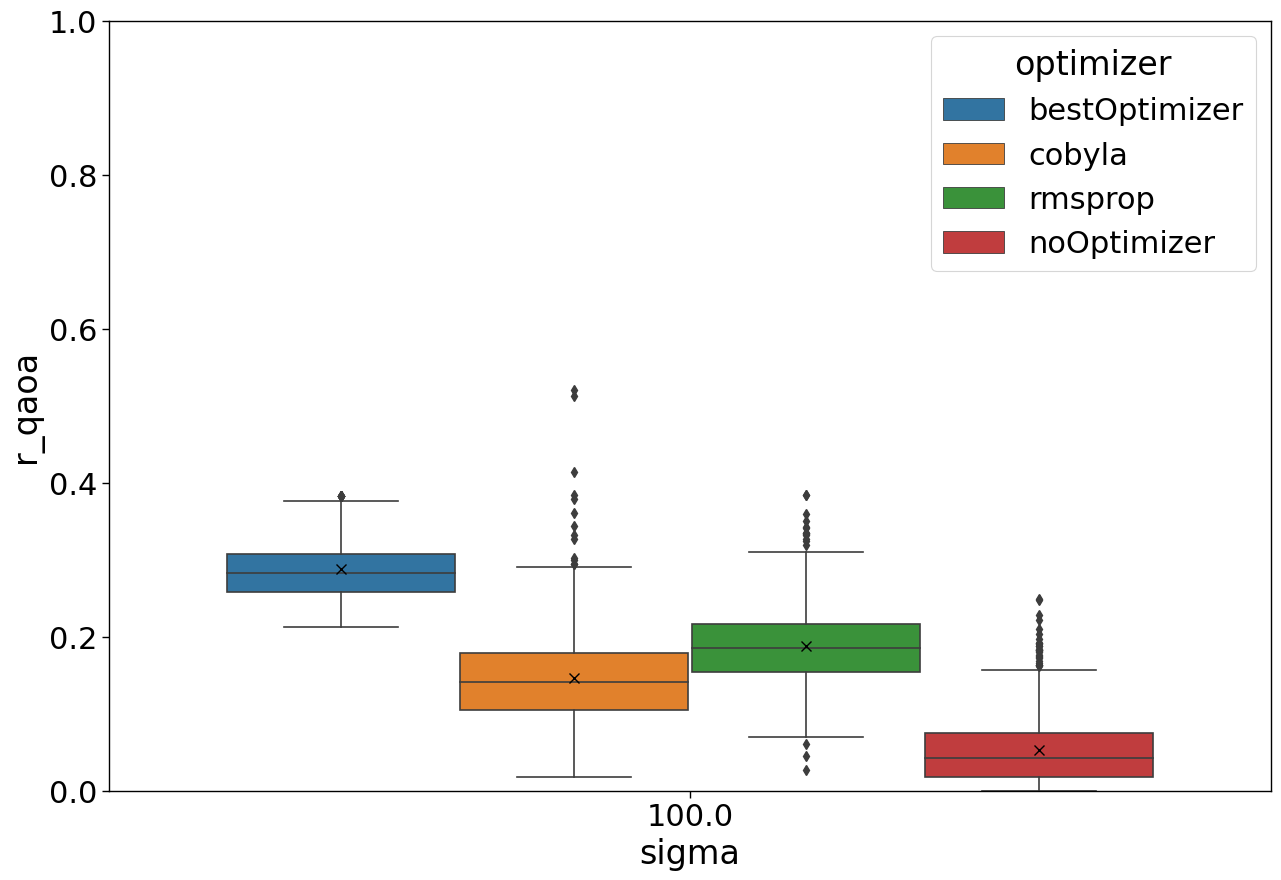

In [15]:
#plt.xscale('log')
plt.ylim(0, 1)

#sns.boxplot(data = df, x = 'sigma', y ='r', hue="optimizer", showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"7"}) # averaging both over graph instances and initial seeds
#plt.savefig("{}_sigma=100.png".format(experiment_name))

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='init_seed') # shows which initialization is the best on average
## i.e. one seed to initialize them all
#plt.savefig("{}_sigma=100.png".format(experiment_name))

sns.boxplot(data = df, x = 'sigma', y ='r_qaoa', hue="optimizer", showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"7"})
plt.savefig("{}_qaoa_sigma=100.png".format(experiment_name))

#sns.boxplot(data = df, x = 'sigma', y ='r_qaoa_most_probable', hue="optimizer", showmeans=True, meanprops={"marker":"x", "markeredgecolor":"black", "markersize":"7"})
#plt.savefig("{}_qaoa_most_probable_sigma=100.png".format(experiment_name))

## Analyze experiment Lower tolerance

In [ ]:
experiment_name='Maxcut_w3R_initializations_lower_tol'

mu = 5.0

sigma_list = [0.1, 1, 10, 100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla"]
graph_seed_list = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
init_seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]


data = []

for sigma in sigma_list:
    print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            for init_seed in init_seed_list:
                print("init_seed=", init_seed)
                
                # Opening JSON file
                with open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed)) as f:

                    # returns JSON object as a dictionary
                    opt_results = json.load(f)

                    # construct the original problem Hamiltonian from the initial QAOA 
                    qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                    terms = []
                    for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                        terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                    weights = qaoa_init['cost_hamiltonian']['coeffs']
                    const = qaoa_init['cost_hamiltonian']['constant']

                    cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                    # Calculate the approx. ratio
                    optimization_energy = list(opt_results['solution'].values())[0]

                    r = np.abs(optimization_energy) / np.abs(analytical_energy)

                    # Extract other params
                    optimization_schedule = list(opt_results['schedule'])

                    optimization_angles = np.array(opt_results['intermediate_steps'][3]['QAOA']['intermediate']['angles log'])
    
                    data.append([sigma, graph_seed, init_seed, optimizer, r])
        


In [ ]:
df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'init_seed', 'optimizer', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['init_seed'] = df['init_seed'].astype(int)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)

df.to_csv("{}_lower_tol.csv".format(experiment_name))

In [ ]:
#plt.xscale('log')
#plt.ylim(0, 1)

sns.boxplot(data = df, x = 'sigma', y ='r') # averaging both over graph instances and initial seeds
plt.savefig("{}.png".format(experiment_name))

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='init_seed') # shows which initialization is the best on average
#plt.savefig("{}_init_seed.png".format(experiment_name))


In [ ]:
# Showing that the initial conditions heavily change the performance

In [ ]:
experiment_name='Maxcut_w3R_initializations_smaller_region'

mu = 5.0

sigma_list = [0.1, 1, 10, 100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla"]
graph_seed_list = [51,  52,  53,  54,  55 ]
init_seed_list = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]


data = []

for sigma in sigma_list:
    print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            for init_seed in init_seed_list:
                print("init_seed=", init_seed)
                
                # Opening JSON file
                with open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__initSeed_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, init_seed)) as f:

                    # returns JSON object as a dictionary
                    opt_results = json.load(f)

                    # construct the original problem Hamiltonian from the initial QAOA 
                    qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                    terms = []
                    for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                        terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                    weights = qaoa_init['cost_hamiltonian']['coeffs']
                    const = qaoa_init['cost_hamiltonian']['constant']

                    cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                    # Calculate the approx. ratio
                    optimization_energy = list(opt_results['solution'].values())[0]

                    r = np.abs(optimization_energy) / np.abs(analytical_energy)

                    # Extract other params
                    optimization_schedule = list(opt_results['schedule'])

                    optimization_angles = np.array(opt_results['intermediate_steps'][3]['QAOA']['intermediate']['angles log'])
    
                    data.append([sigma, graph_seed, init_seed, optimizer, r])
        


In [ ]:
df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'init_seed', 'optimizer', 'r'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['init_seed'] = df['init_seed'].astype(int)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)

#df.to_csv("{}.csv".format(experiment_name))

In [ ]:
experiment_name

In [ ]:
#plt.xscale('log')
#plt.ylim(0, 1)

#sns.boxplot(data = df, x = 'sigma', y ='r') # averaging both over graph instances and initial seeds
#plt.savefig("{}.png".format(experiment_name))

sns.boxplot(data = df, x = 'sigma', y ='r', hue='graph_seed') # shows which initialization is the best on average
plt.savefig("{}_cobyla_init_seed.png".format(experiment_name))


## Run experiment: adaptive vs custom with a fixed elimination step

In [ ]:
def run_Rqaoa_experiment_rqaoa_type(sigma, graph_seed, optimizer, rqaoa_type, experiment_name='Maxcut_w3R_vanilla_custom_adaptive_2'):  
    
    mu = 5.0
    k = 3
    n = 12
    steps = 2
    
    # experiment_name = name of the folder to contain all data for this experiment
    # structure of the name: problem_typeOfGraph[optional]_variableToInvestigate
    
    g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

    # Define te problem and translate it into a binary Qubo.
    maxcut_prob = MaximumCut(g)
    maxcut_qubo = maxcut_prob.get_qubo_problem()

    
    # Define the RQAOA object 
    R = RQAOA()

    # Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3
    if rqaoa_type == "custom":
        R.set_rqaoa_parameters(n_cutoff = 3, steps = steps, rqaoa_type = rqaoa_type)
    elif rqaoa_type == "adaptive":
        R.set_rqaoa_parameters(n_cutoff = 3, n_max = 2*steps, rqaoa_type = rqaoa_type)
    elif rqaoa_type == "vanilla":
        R.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

    ## Setting up the QAOA properties

    # Set the properties you want - These values are actually the default ones!
    #R.set_circuit_properties(p=1, param_type='standard', init_type='ramp', mixer_hamiltonian='x')
    

    R.set_circuit_properties(p=1, init_type='ramp', mixer_hamiltonian='x')

    # Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
    device = create_device(location='local', name='vectorized')
    R.set_device(device)

    # Set the classical method used to optimiza over QAOA angles and its properties
    R.set_classical_optimizer(method=optimizer, 
                              optimizer_options = {"stepsize" : 0.01},
                              tol=10**(-3), maxfev=2000, maxiter=2000, 
                              jac='finite_difference',
                              #parameter shift
                              hess='finite_difference',
                              optimization_progress=False, 
                              cost_progress=True, parameter_log=True)

    # Here are other ways in which the above selection can be generalized!

    # device = create_device(location = 'qcs',name = 'Aspen-11', as_qvm = True, client_configuraton = qcs_credentials)
    # r.set_device(device)
    # r.set_backend_properties(n_shots=100, cvar_alpha=1)
    # r.set_circuit_properties(param_type = 'extended', init_type = 'fourier_extended')
    # r.set_classical_optimizer(method='Nelder-Mead', maxiter=1000)
    

    # Compile problem instance on RQAOA, just like with QAOA
    R.compile(maxcut_qubo)
    
    R.optimize()
    
    try: 
        os.mkdir(experiment_name) 
    except OSError as error: 
        pass # TODO not sure if the best way to handle this  
    
    # TODO save in the backup folder directly
    R.results.dump("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__type_{}__steps_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, rqaoa_type, steps))
    
# What if in a couple of days I decide that I want to vary the cutoff too? 
## Then I will have to add this to the name of the file and then it will get cumbursome to compare files from different folders


In [ ]:
sigma_list = [1, 10]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla"]
graph_seed_list = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
rqaoa_type_list = ["vanilla", "custom", "adaptive"]

joblib.Parallel(n_jobs=16)(joblib.delayed(run_Rqaoa_experiment_rqaoa_type)(sigma, graph_seed, optimizer, rqaoa_type) for sigma in sigma_list for graph_seed in graph_seed_list for optimizer in optimizer_list for rqaoa_type in rqaoa_type_list)
 

## Analyze Experiment

In [ ]:
optimization_schedule

In [ ]:
np.average(optimization_schedule)

In [ ]:
experiment_name = 'Maxcut_w3R_vanilla_custom_adaptive_2' # to be used as a name for the folder containing all jsons for this experiment 
# structure of the name: problem_typeOfGraph[optional]_variableToInvestigate

mu = 5.0

sigma_list = [0.1, 1, 10, 100]
#optimizer_list = ["vgd", "rmsprop", 'newton-cg', 'cobyla', 'nelder-mead', 'powell' ]
optimizer_list = ["cobyla"]
graph_seed_list = [1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
rqaoa_type_list = ["vanilla", "custom", "adaptive"]
steps = 2

data = []


for sigma in sigma_list:
    print("Sigma=", sigma) 
    for graph_seed in graph_seed_list:
        print("graph_seed=", graph_seed)
        for optimizer in optimizer_list:
            print("Optimizer=", optimizer)
            for rqaoa_type in rqaoa_type_list:
                print("rqaoa_type=", rqaoa_type)
                
                
                # Opening JSON file
                with open("{}/mu_{}__sigma_{}__graphSeed_{}_optimizer_{}__type_{}__steps_{}.json".format(experiment_name, mu, sigma, graph_seed, optimizer, rqaoa_type, steps)) as f:
   
                    # returns JSON object as a dictionary
                    opt_results = json.load(f)

                    # construct the original problem Hamiltonian from the initial QAOA 
                    qaoa_init = opt_results['intermediate_steps'][0]['QAOA']
                    terms = []
                    for i in range(0, len(qaoa_init['cost_hamiltonian']['terms'])):
                        terms.append(qaoa_init['cost_hamiltonian']['terms'][i]['qubit_indices'])
                    weights = qaoa_init['cost_hamiltonian']['coeffs']
                    const = qaoa_init['cost_hamiltonian']['constant']

                    cost_hamiltonian = Hamiltonian.classical_hamiltonian(terms, weights, const)

                    analytical_energy, configuration = ground_state_hamiltonian(cost_hamiltonian)

                    # Calculate the approx. ratio
                    optimization_energy = list(opt_results['solution'].values())[0]

                    r = np.abs(optimization_energy) / np.abs(analytical_energy)

                    # Extract other params
                    optimization_schedule = list(opt_results['schedule'])
                    
                    avr_schedule = np.average(optimization_schedule)

                    #optimization_angles = np.array(opt_results['intermediate_steps'][-1]['QAOA']['intermediate']['angles log'])
    
                    data.append([sigma, graph_seed, rqaoa_type, optimizer, r, optimization_schedule, avr_schedule])
        



In [ ]:
df = pd.DataFrame(np.array(data), columns=['sigma', 'graph_seed', 'rqaoa_type', 'optimizer', 'r', 'schedule', 'avr_schedule'])

df['sigma'] = df['sigma'].astype(float)
df['graph_seed'] = df['graph_seed'].astype(int)
df['rqaoa_type'] = df['rqaoa_type'].astype(str)
df['optimizer'] = df['optimizer'].astype(str)
df['r'] = df['r'].astype(float)
df['avr_schedule'] = df['avr_schedule'].astype(float)

df.to_csv("{}.csv".format(experiment_name))

In [ ]:
df

In [ ]:
#plt.xscale('log')
#plt.ylim(0, 1)

sns.boxplot(data = df, x = 'sigma', y ='r', hue='rqaoa_type') # averaging both over graph instances and initial seeds
plt.savefig("{}.png".format(experiment_name))

#sns.boxplot(data = df, x = 'sigma', y ='r', hue='init_seed') # shows which initialization is the best on average
#plt.savefig("{}_init_seed.png".format(experiment_name))


### Average elimination in the adaptive method 

In [ ]:
ada_df = df[df['rqaoa_type'] == "adaptive"]
ada_df

In [ ]:
ada_df_100 = ada_df[df['sigma'] == 100]

In [ ]:
ada_df_01

In [ ]:
avr_schedule = ada_df_100["avr_schedule"].mean()
avr_schedule

### Code profiling: Time it!

In [ ]:
%%timeit


mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3

# vanilla
R.set_rqaoa_parameters(n_cutoff = 3, steps = 1, rqaoa_type = 'custom')

R.set_circuit_properties(p=1, init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()

In [ ]:
%%timeit

mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3

R.set_rqaoa_parameters(n_cutoff = 3, steps = steps, rqaoa_type = "custom")

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()

In [ ]:
%%timeit


mu = 5.0
k = 3
n = 12
steps = 2
graph_seed = 1
sigma=1
optimizer = "cobyla"

g = random_k_regular_graph_normal_distribution(degree=k, nodes=range(n), seed=graph_seed, weighted=True, mu=mu, sigma=sigma, biases=False) 

# Define te problem and translate it into a binary Qubo.
maxcut_prob = MaximumCut(g)
maxcut_qubo = maxcut_prob.get_qubo_problem()


# Define the RQAOA object 
R = RQAOA()

# Set parameters for RQAOA, in this case we fix the n_max to 1 (default), the final cutoff value to 3


R.set_rqaoa_parameters(n_cutoff = 3, n_max = 2*steps, rqaoa_type = "adaptive")

R.set_circuit_properties(p=1, init_type='ramp', mixer_hamiltonian='x')

# Define the device you want to run your problem on using the create_device() function - Here we choose the local wavefunction simulator supported by OpenQAOA
device = create_device(location='local', name='vectorized')
R.set_device(device)

# Set the classical method used to optimiza over QAOA angles and its properties
R.set_classical_optimizer(method=optimizer, 
                          optimizer_options = {"stepsize" : 0.01},
                          tol=10**(-3), maxfev=2000, maxiter=2000, 
                          jac='finite_difference',
                          #parameter shift
                          hess='finite_difference',
                          optimization_progress=False, 
                          cost_progress=True, parameter_log=True)

# Compile problem instance on RQAOA, just like with QAOA
R.compile(maxcut_qubo)

R.optimize()